CNN : 합성층을 반복적으로 쌓아서 만든 인공신경망
원본이미지를 합성곱 커널이 이동하면서 특징 맵을 만듦

데이터 전처리

100%|██████████| 170498071/170498071 [00:04<00:00, 41243246.91it/s]


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


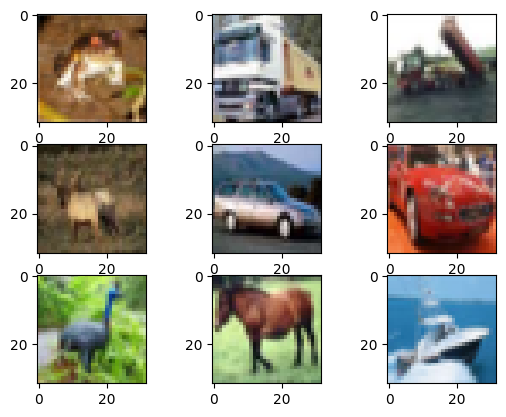

In [ ]:
import matplotlib.pyplot as plt

from torchvision.datasets.cifar import CIFAR10
from torchvision.transforms import ToTensor

training_data = CIFAR10(
    root = "./",
    train = True,
    download = True,
    transform = ToTensor()
)

test_data = CIFAR10(
    root = "./",
    train = False,
    download = True,
    transform = ToTensor()
)

for i in range(9):
  plt.subplot(3,3,i+1)
  plt.imshow(training_data.data[i])
plt.show()

데이터 증강

Files already downloaded and verified
Files already downloaded and verified


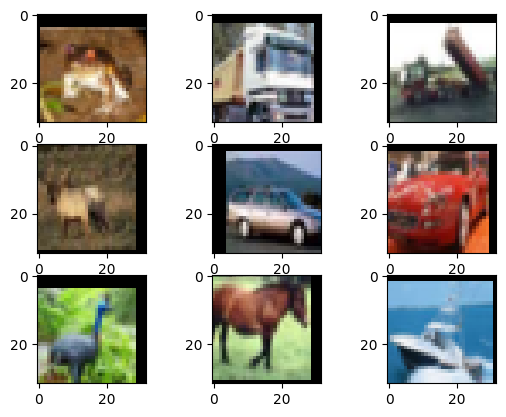

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms as T

from torchvision.datasets.cifar import CIFAR10
from torchvision.transforms import Compose
from torchvision.transforms import RandomHorizontalFlip, RandomCrop

transforms = Compose([
    T.ToPILImage(),
    RandomCrop((32,32), padding=4),
    RandomHorizontalFlip(p=0.5)
])

training_data = CIFAR10(
    root = "./",
    train = True,
    download = True,
    transform = transforms
)

test_data = CIFAR10(
    root = "./",
    train = False,
    download = True,
    transform = transforms
)

for i in range(9):
  plt.subplot(3,3,i+1),
  plt.imshow(transforms(training_data.data[i]))
plt.show()

이미지 정규화

Files already downloaded and verified
Files already downloaded and verified


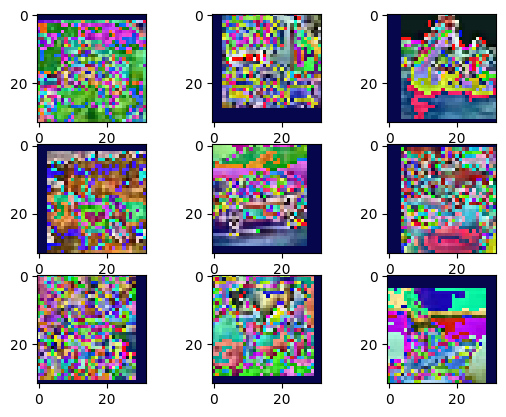

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms as T

from torchvision.datasets.cifar import CIFAR10
from torchvision.transforms import Compose
from torchvision.transforms import RandomHorizontalFlip, RandomCrop, Normalize

transforms = Compose([
    T.ToPILImage(),
    RandomCrop((32,32), padding = 4),
    RandomHorizontalFlip(p=0.5),
    T.ToTensor(),

    Normalize(mean=(0.4914,0.4822,0.4465),std=(0.247, 0.243,0.261)),
    T.ToPILImage()
])

training_data = CIFAR10(
    root="./",
    train= True,
    download=+True
)
test_data = CIFAR10(
    root="./",
    train=False,
    download=True,
    transform=transforms
)

for i in range(9):
  plt.subplot(3,3,i+1)
  plt.imshow(transforms(training_data.data[i]))
plt.show()

CIFAR10 데이터의 평균, 표준편차

In [ ]:
import torch

training_data = CIFAR10(
    root = "./",
    train = True,
    download = True,
    transform = ToTensor()
)

imgs = [item[0] for item in training_data]

imgs = torch.stack(imgs, dim=0).numpy()

mean_r = imgs[:,0,:,:].mean()
mean_g = imgs[:,1,:,:].mean()
mean_b = imgs[:,2,:,:].mean()
print(mean_r,mean_g,mean_b)

std_r = imgs[:,0,:,:].std()
std_g = imgs[:,1,:,:].std()
std_b = imgs[:,2,:,:].std()
print(std_r, std_g, std_b)

Files already downloaded and verified
0.49139968 0.48215827 0.44653124
0.24703233 0.24348505 0.26158768


VGG 기본 블록 설계

In [ ]:
import torch.nn as nn

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_dim):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, hidden_dim, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(hidden_dim, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)

        return x

CNN 모델 정의

In [ ]:
class CNN(nn.Module):
  def __init__(self, num_classes):
    super(CNN, self).__init__()

    self.block1 = BasicBlock(in_channels = 3, out_channels = 32, hidden_dim=16)
    self.block2 = BasicBlock(in_channels = 32, out_channels = 128, hidden_dim=64)
    self.block3 = BasicBlock(in_channels = 128, out_channels = 256, hidden_dim = 128)

    self.fc1 = nn.Linear(in_features=4096, out_features = 2048)
    self.fc2 = nn.Linear(in_features=2048, out_features = 256)
    self.fc3 = nn.Linear(in_features=256, out_features = num_classes)

    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    x = torch.flatten(x, start_dim = 1)

    x = self.fc1(x)
    x = self.fc2(x)
    x = self.relu(x)
    x = self.fc3(x)

    return x

데이터 전처리, 증강

In [ ]:
from torchvision.datasets.cifar import CIFAR10
from torchvision.transforms import Compose
from torchvision.transforms import RandomHorizontalFlip, RandomCrop, Normalize
from torch.utils.data.dataloader import DataLoader

from torch.optim.adam import Adam

transforms = Compose([
    RandomCrop((32,32), padding = 4),
    RandomHorizontalFlip(p=0.5),
    T.ToTensor(),

    Normalize(mean=(0.4914,0.4822,0.4465),std=(0.247, 0.243,0.261))])

모델 정의 및 데이터 호출

In [ ]:
training_data = CIFAR10(root = "./", train= True, download= True, transform=transforms)
test_data = CIFAR10(root = "./", train= False, download= True, transform=transforms)

train_loader = DataLoader(training_data, batch_size=32, shuffle = True)
test_loader = DataLoader(test_data, batch_size=32, shuffle = False)

device = "cuda" if torch.cuda.is_available() else "cpu"

model = CNN(num_classes=10)

model.to(device)

Files already downloaded and verified
Files already downloaded and verified


CNN(
  (block1): BasicBlock(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): BasicBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): BasicBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=4096, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=256,

모델 학습

In [ ]:
lr = 1e-3

optim = Adam(model.parameters(), lr=lr)

for epoch in range(100):
  for data, label in train_loader:
    optim.zero_grad()

    preds = model(data.to(device))

    loss = nn.CrossEntropyLoss()(preds, label.to(device))
    loss.backward()
    optim.step()

  if epoch == 0 or epoch%10 == 9:
    print(f"epoch{epoch+1} loss:{loss.item()}")

torch.save(model.state_dict(), "CIFAR.pth")

epoch1 loss:1.3760496377944946
epoch10 loss:0.8775712251663208
epoch20 loss:0.6094064116477966
epoch30 loss:1.1210845708847046
epoch40 loss:0.3101365864276886
epoch50 loss:0.4704013466835022
epoch60 loss:0.16950951516628265
epoch70 loss:0.14480286836624146
epoch80 loss:0.29667845368385315
epoch90 loss:0.6361231207847595
epoch100 loss:0.32466810941696167


모델 평가

In [ ]:
model.load_state_dict(torch.load("CIFAR.pth", map_location=device))

num_corr = 0

with torch.no_grad():
  for data, label in test_loader:

    output = model(data.to(device))
    preds = output.data.max(1)[1]
    corr = preds.eq(label.to(device).data).sum().item()
    num_corr += corr

  print(f"Acurracy:{num_corr/len(test_data)}")

Acurracy:0.708
